# Interprétation de modèles de machine learning

## Introduction

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## Compréhension des données

### Lecture et préparation

On charge les données à l'aide d'un dataframe pandas et on affiche une partie des données

In [27]:
 # On charge les données depuis Github pour la portabilité du notebook.
df = pd.read_csv("https://raw.githubusercontent.com/uazech/DLime/master/KaggleV2-May-2016.csv")
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


On regarde les différentes variables et le typage des données. 


In [28]:
df.dtypes

PatientId         float64
AppointmentID       int64
Gender             object
ScheduledDay       object
AppointmentDay     object
Age                 int64
Neighbourhood      object
Scholarship         int64
Hipertension        int64
Diabetes            int64
Alcoholism          int64
Handcap             int64
SMS_received        int64
No-show            object
dtype: object

Les deux features ScheduledDay et AppointmentDay devraient être de type date. On caste donc les deux colonnes. On caste également la cible en entier, 0 indiquant que la personne n'est pas allée à son RDV et 1 qu'elle y est allée.



In [29]:
df['ScheduledDay'] =  pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay'] =  pd.to_datetime(df['AppointmentDay'])

df["target"]= (df["No-show"] == "Yes").astype("int8")
df = df.drop("No-show", axis=1)
df.dtypes

PatientId                     float64
AppointmentID                   int64
Gender                         object
ScheduledDay      datetime64[ns, UTC]
AppointmentDay    datetime64[ns, UTC]
Age                             int64
Neighbourhood                  object
Scholarship                     int64
Hipertension                    int64
Diabetes                        int64
Alcoholism                      int64
Handcap                         int64
SMS_received                    int64
target                           int8
dtype: object

Le typage des données semble correct.


On étudie la proportion de valeur manquante. 

In [30]:
df.isna().sum()

PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
target            0
dtype: int64

Il n'y a aucune donnée manquante à priori. 

On étudie le nombre de modalité unique par colonne.

In [31]:
df.nunique()

PatientId          62299
AppointmentID     110527
Gender                 2
ScheduledDay      103549
AppointmentDay        27
Age                  104
Neighbourhood         81
Scholarship            2
Hipertension           2
Diabetes               2
Alcoholism             2
Handcap                5
SMS_received           2
target                 2
dtype: int64

On remarque que les colonnes patientId et AppointmentID sont inutiles. On décidera de garder l'AppointmentID en index du dataframe, car chaque ID correspond à une ligne unique.

Les variables booléenes possèdent bien 2 modalités, à l'exception de handcap. Il faudra étudier plus en détail cette variable afin de comprendre pourquoi il y a 5 modalités différentes.

On remarque enfin que la colonne "AppointmentDay" ne possède que 27 valeurs différentes. Il sera compliqué de réaliser du feature engineering sur cette variable.

Nous essaierons également de traiter la variable Neighbourhood qui correspond à une zone géographique afin du juger de sa pertinence.


On redéfini l'index et on supprime la colonne PatientId

In [0]:
df.set_index('AppointmentID')
df = df.drop("PatientId", axis=1)

On réalise du feature engineering pour garder les notions suivantes sur les champs dates :
* Le timestamp permettant de garder la continuité des variables temporelles
* Le mois et l'année 
* Le jour de la semaine

On calcule également la différence entre l'appointment day et le scheduled day pour avoir le nombre d'heure avant le rendez-vous.

In [0]:
# Feature engineering pour le ScheduledDay
df['ScheduledYear'] = pd.DatetimeIndex(df['ScheduledDay']).year 
df['ScheduledMonth'] = pd.DatetimeIndex(df['ScheduledDay']).month
df['ScheduledHour'] = pd.DatetimeIndex(df['ScheduledDay']).hour
df['ScheduledDayOfWeek'] = pd.DatetimeIndex(df['ScheduledDay']).dayofweek.map(
    {0:"lundi", 1:"mardi", 2:"mercredi", 3:"jeudi", 4:"vendredi", 5:"samedi", 6:"dimanche"})
df['ScheduledTimestamp'] = df.ScheduledDay.values.astype(np.int64) // 10 ** 9 

# Feature engineering pour l'AppointmentDay
df['AppointmentYear'] = pd.DatetimeIndex(df['AppointmentDay']).year 
df['AppointmentMonth'] = pd.DatetimeIndex(df['AppointmentDay']).month
df['AppointmentHour'] = pd.DatetimeIndex(df['AppointmentDay']).hour 
df['AppointmentDayOfWeek'] = pd.DatetimeIndex(df['AppointmentDay']).dayofweek
df['AppointmentTimestamp'] = df.AppointmentDay.values.astype(np.int64) // 10 ** 9 

# Calcul de la variable nbHeureAvantRDV
df['nbHeureAvantRDV'] = (pd.DatetimeIndex(df['AppointmentDay']) - pd.DatetimeIndex(df['ScheduledDay'])).seconds / 3600

### Analyse des données

On trace des histogrammes pour les variables numériques afin d'étudier la répartition.

In [34]:
df.nunique()

AppointmentID           110527
Gender                       2
ScheduledDay            103549
AppointmentDay              27
Age                        104
Neighbourhood               81
Scholarship                  2
Hipertension                 2
Diabetes                     2
Alcoholism                   2
Handcap                      5
SMS_received                 2
target                       2
ScheduledYear                2
ScheduledMonth               8
ScheduledHour               16
ScheduledDayOfWeek           6
ScheduledTimestamp      103549
AppointmentYear              1
AppointmentMonth             3
AppointmentHour              1
AppointmentDayOfWeek         6
AppointmentTimestamp        27
nbHeureAvantRDV          37109
dtype: int64

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


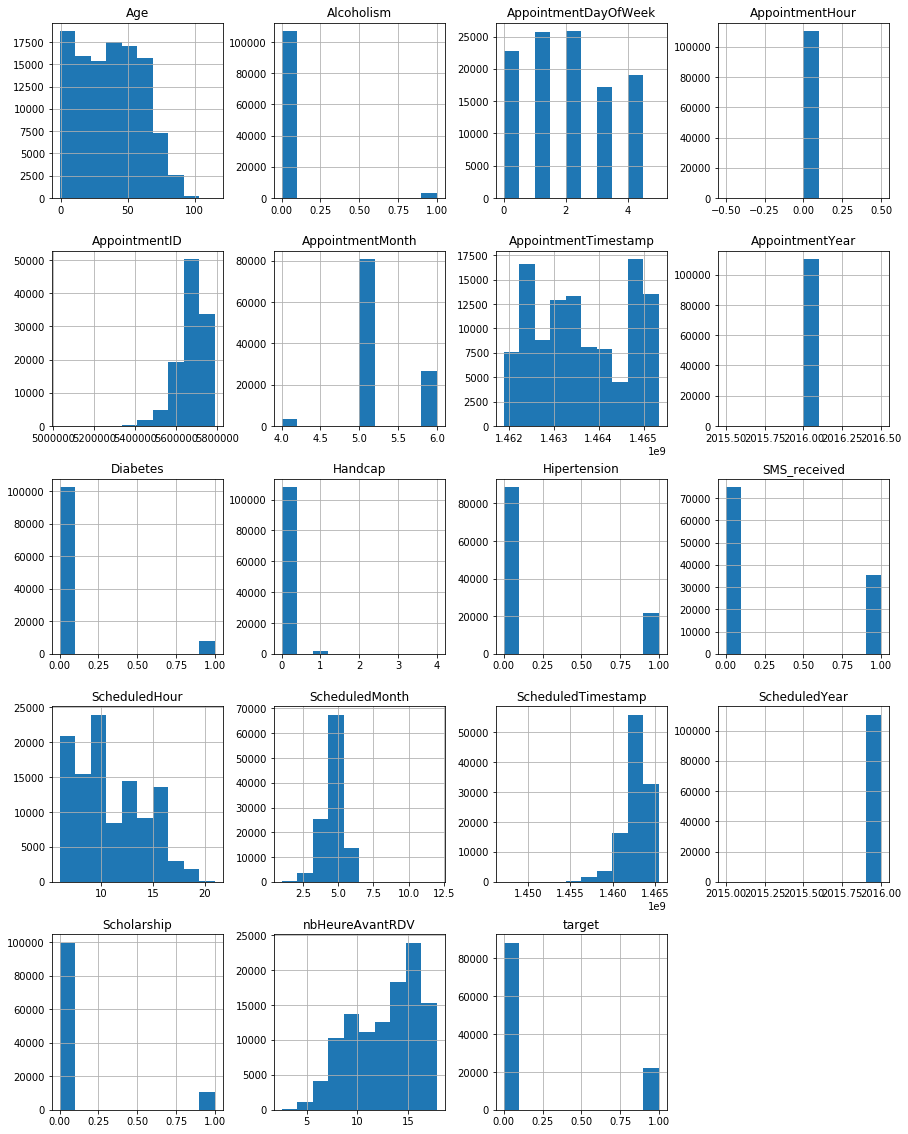

In [35]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df.hist(ax = ax)
plt.show()

Il y a beaucoup de choses à dire à propos de ces histogrammes :
* La cible est très déséquilibrée. Il faudra faire attention à l'interprétation des résultats des modèles.
* Les données ScheduledYear, AppointmentYear et AppointmentHour sont trop homogènes et ne peuvent donc pas apporter beaucoup d'information. Il faudra les supprimer.
* Les données de types booléenes sont mals réparties, et penchent pour des situation normales. La variable Handcap 